In [ ]:
"""
major reference: 
https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
"""

In [1]:
%matplotlib inline
import audiolazy
import librosa
import re
import argparse
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from scipy.signal import butter, lfilter, filtfilt, freqz
import wave    # python built-in wave library

In [2]:
# FFT configure
FFT_FRAME_LENGTH = 50 # millisecond
FFT_HOP_RATIO = 0.25 # 
FFT_WINDOW = 'hann' # default is 'hann'
FFT_TOP_DB = 200 # 
def librosa_stft_to_db(signal=None, db_ref=1.0, top_db=80.0):
    x = signal
    x = x.astype(np.float32)
    frame_len = FFT_FRAME_LENGTH
    n_fft = int(fs * frame_len / 1000)
    hop_len = int(FFT_HOP_RATIO * n_fft)
    x = librosa.stft(x, n_fft=n_fft, hop_length=hop_len, window=FFT_WINDOW)
    #x = librosa.stft(x)
    x = librosa.amplitude_to_db(x, ref=db_ref, top_db=top_db)
    return x, n_fft, hop_len

def load_raw(wave_path):
    ''' use built-in library to load unmodified wave sound, return type is np.int16 '''
    wave_obj = wave.open(wave_path, 'rb')
    byte_string = wave_obj.readframes(wave_obj.getnframes()) # -1 also fine
    n_channel = wave_obj.getnchannels()
    bytes_per_sample = wave_obj.getsampwidth()
    sample_rate = wave_obj.getframerate()
    # convert byte string to numpy array
    dtype = np.int16 if bytes_per_sample == 2 else np.int8
    signal = np.fromstring(byte_string, dtype=dtype)
    return signal, sample_rate


In [3]:
#wave_path = '/home/alvin/cei/notebook_home/EyesInTheSky/pkg/tflab/heart_whisper/201101070538.wav'
wave_path = '/home/alvin/cei/notebook_home/EyesInTheSky/pkg/tflab/heart_whisper/103_1305031931979_B.wav'
signal, fs = load_raw(wave_path)
#g,fs = librosa.load(')
x_fft,n_fft,hop_len = librosa_stft_to_db(signal)

In [4]:
def apply_filter(x, filter,sample_rate):
    assert isinstance(x, np.ndarray)
    assert isinstance(x[0], (np.float32, np.int16, np.int8))
    #filter string error handling
    if filter is None or filter is str(""):
        return x
    if re.search('[a-z]',filter,re.IGNORECASE):
        print('[INFO] invalid content in Freq .Filter')
        return x
    #procee high/low/stop band filter
    nyq = sample_rate/2
    BUTTER_ORDER = 6
    filter_list = filter.split(',')
    for filter_item in filter_list:
        lowpass_flag = re.match('(\d+)\+$',filter_item)
        highpass_flag = re.match('(\d+)\-$',filter_item)
        bandstop_flag = re.match('(\d+)\-(\d+)$',filter_item)
        if lowpass_flag:
            #low pass filter
            normal_cutoff = float(lowpass_flag.group(1)) / nyq
            b, a = butter(BUTTER_ORDER, normal_cutoff, btype='low', analog=False)
            x    = lfilter(b, a, x)
        if highpass_flag:
            #high pass filter
            normal_cutoff = float(highpass_flag.group(1)) / nyq
            b, a = butter(BUTTER_ORDER, normal_cutoff, btype='high', analog=False)                
            x = filtfilt(b, a, x)
        if bandstop_flag:
            #band stop filter
            low =  int(bandstop_flag.group(1))/ nyq
            high = int(bandstop_flag.group(2))/ nyq
            b, a = butter(BUTTER_ORDER, [low,high], btype='stop',analog=False)
            maxx = np.max(x)
            x = lfilter(b, a, x)
            x = np.minimum(x,maxx)
    return x

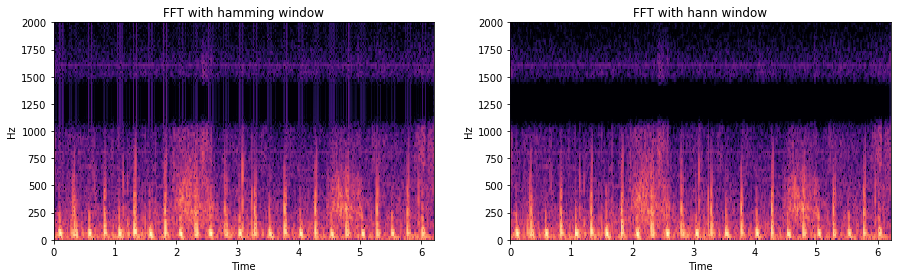

In [6]:
orig_min_db = np.min(x_fft)
orig_max_db = np.max(x_fft)

# process filter data
x = apply_filter(signal,'1000-1500',fs)
x = x.astype(np.float32)
fig,ax = plt.subplots(1,2,figsize=(15,4))

plt.subplot(1,2,1)
FFT_WINDOW = 'hamming' # default is 'hann'
x1,n_fft,hop_len = librosa_stft_to_db(x)
librosa.display.specshow(x1, sr=fs, hop_length=hop_len, x_axis='time', y_axis='hz')
plt.clim(orig_min_db,orig_max_db)
plt.title('FFT with '+FFT_WINDOW+' window')

plt.subplot(1,2,2)
FFT_WINDOW = 'hann' # default is 'hann'
x2,n_fft,hop_len = librosa_stft_to_db(x)
librosa.display.specshow(x2, sr=fs, hop_length=hop_len, x_axis='time', y_axis='hz')
plt.clim(orig_min_db,orig_max_db)
plt.title('FFT with '+FFT_WINDOW+' window')



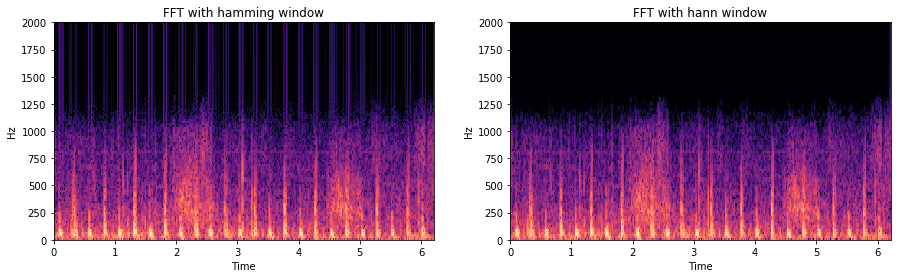

In [7]:

# process filter data
x = apply_filter(signal,'1000+',fs)
x = x.astype(np.float32)
fig,ax = plt.subplots(1,2,figsize=(15,4))

plt.subplot(1,2,1)
FFT_WINDOW = 'hamming' # default is 'hann'
x1,n_fft,hop_len = librosa_stft_to_db(x)
librosa.display.specshow(x1, sr=fs, hop_length=hop_len, x_axis='time', y_axis='hz')
plt.clim(orig_min_db,orig_max_db)
plt.title('FFT with '+FFT_WINDOW+' window')

plt.subplot(1,2,2)
FFT_WINDOW = 'hann' # default is 'hann'
x2,n_fft,hop_len = librosa_stft_to_db(x)
librosa.display.specshow(x2, sr=fs, hop_length=hop_len, x_axis='time', y_axis='hz')
plt.clim(orig_min_db,orig_max_db)
plt.title('FFT with '+FFT_WINDOW+' window')


# Hann/Hamming window on time domain and frequency domain

<table>
<tr><td>
![Bilby Stampede](https://www.tek.com/sites/default/files/u811871/hamming-t.png)
</td>
<td>
![Bilby Stampede](https://www.tek.com/sites/default/files/u811871/hamming-f.png)
</td></tr>
</table>